<h1>Forecasting Test 1<h1>

1. Converting dataframe dates to months only.
2. Will be testing LSTM vs ARIMA model performance using RMSE.
3. Predict 6 months using the best model.
4. Comparing with actual data to check accuracy of predict.

<h4>Data Cleaning<h4>

In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import KFold
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

df = pd.read_csv('.\Datasets\CR_COST_FC_new.csv', converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})
df['POD'] = pd.to_datetime(df['POD'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
df = df.dropna(subset=['ENCODED_TYPE'])
df['RATE'] = df['RATE'].fillna(-1).astype(int)
df = df.dropna(subset=['RATE'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)

# Remove NAN values
df_clean= df.dropna().reset_index(drop=True)

df_clean.head()
df_clean.info()
print(f'Dataset size: {df_clean.shape}')

,COM_ID,PARTY_ID,PARTY_ID_EN,PARTY_NAME,CSL_ID,ETA_ETD_NO,ETD_POL_D,POD_ID,POD,CNTR_ID,CNTR_SIZE,CNTR_TYPE,COST_TERM,RATE,ENCODED_TYPE,ENCODED_TERM,POD_ID_EN
0,010,010003678,10003678,OY TAVATUR SHIPPING LTD,ECS010060100191,20060228,FIHEL,HELSINKI,2006-02-28,CTNR010060201232,20,GP,FC,675,2,1,4.103561e+09
1,010,010004286,10004286,"GLOBELINK KOREA CO., LTD",ECS010060100465,20060303,KRPUS,BUSAN,2006-03-03,CTNR010060300014,40,HC,FC,390,1,1,2.904902e+09
2,010,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,ECS010060100321,20060227,NZAKL,AUCKLAND,2006-02-27,CTNR010060201198,40,HC NOR,FC,1615,4,1,2.397848e+09
3,010,01002775,1002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,ECS010060200201,20060306,AUADL,ADELAIDE,2006-03-06,CTNR010060300119,40,HC,FC,700,1,1,2.480737e+08
4,010,01001088,1001088,CARGO LINES S.A.-LE HAVRE,ECS010060200146,20060307,FRMRS,MARSEILLE,2006-03-07,CTNR010060300185,20,GP,FC,675,2,1,4.197227e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54722 entries, 0 to 54721
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        54722 non-null  object        
 1   PARTY_ID      54722 non-null  object        
 2   PARTY_ID_EN   54722 non-null  int64         
 3   PARTY_NAME    54722 non-null  object        
 4   CSL_ID        54722 non-null  object        
 5   ETA_ETD_NO    54722 non-null  int64         
 6   ETD_POL_D     54722 non-null  object        
 7   POD_ID        54722 non-null  object        
 8   POD           54722 non-null  datetime64[ns]
 9   CNTR_ID       54722 non-null  object        
 10  CNTR_SIZE     54722 non-null  object        
 11  CNTR_TYPE     54722 non-null  object        
 12  COST_TERM     54722 non-null  object        
 13  RATE          54722 non-null  int32         
 14  ENCODED_TYPE  54722 non-null  int32         
 15  ENCODED_TERM  54722 non-null  int64 

In [122]:
sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
           'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']

df_fc = df_clean[sel_col]
df_fc.head()
df_fc.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010060100191,CTNR010060201232,HELSINKI,FIHEL,010003678,OY TAVATUR SHIPPING LTD,2006-02-28,20,GP,675
1,ECS010060100465,CTNR010060300014,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2006-03-03,40,HC,390
2,ECS010060100321,CTNR010060201198,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2006-02-27,40,HC NOR,1615
3,ECS010060200201,CTNR010060300119,ADELAIDE,AUADL,01002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,2006-03-06,40,HC,700
4,ECS010060200146,CTNR010060300185,MARSEILLE,FRMRS,01001088,CARGO LINES S.A.-LE HAVRE,2006-03-07,20,GP,675


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54722 entries, 0 to 54721
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      54722 non-null  object        
 1   CNTR_ID     54722 non-null  object        
 2   POD_ID      54722 non-null  object        
 3   ETD_POL_D   54722 non-null  object        
 4   PARTY_ID    54722 non-null  object        
 5   PARTY_NAME  54722 non-null  object        
 6   POD         54722 non-null  datetime64[ns]
 7   CNTR_SIZE   54722 non-null  object        
 8   CNTR_TYPE   54722 non-null  object        
 9   RATE        54722 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 4.0+ MB


In [123]:
# filter out rows where the year is 2002
df_filtered = df_fc[df_fc['POD'].dt.year != 2002]
df_filtered.head()
df_filtered.info()

# Checking if year 2002 is removed
df_filtered['POD'].dt.year.unique()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010060100191,CTNR010060201232,HELSINKI,FIHEL,010003678,OY TAVATUR SHIPPING LTD,2006-02-28,20,GP,675
1,ECS010060100465,CTNR010060300014,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2006-03-03,40,HC,390
2,ECS010060100321,CTNR010060201198,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2006-02-27,40,HC NOR,1615
3,ECS010060200201,CTNR010060300119,ADELAIDE,AUADL,01002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,2006-03-06,40,HC,700
4,ECS010060200146,CTNR010060300185,MARSEILLE,FRMRS,01001088,CARGO LINES S.A.-LE HAVRE,2006-03-07,20,GP,675


<class 'pandas.core.frame.DataFrame'>
Int64Index: 54721 entries, 0 to 54721
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      54721 non-null  object        
 1   CNTR_ID     54721 non-null  object        
 2   POD_ID      54721 non-null  object        
 3   ETD_POL_D   54721 non-null  object        
 4   PARTY_ID    54721 non-null  object        
 5   PARTY_NAME  54721 non-null  object        
 6   POD         54721 non-null  datetime64[ns]
 7   CNTR_SIZE   54721 non-null  object        
 8   CNTR_TYPE   54721 non-null  object        
 9   RATE        54721 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 4.4+ MB


array([2006, 2005, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2018, 2019, 2020, 2021, 2016, 2017, 2022, 2023], dtype=int64)

In [124]:
# Sorting the dates 
df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
df_filtered.head()
df_filtered.tail()
df_filtered['POD'].dt.year.unique()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
54716,ECS010230400526,010000573399,VALPARAISO,CLVAP,010006350,CRAFT MULTIMODAL CHILE SPA,2023-05-24,40,HC,1300
54717,ECS010230400525,010000582631,CALLAO,PECLL,010026711,CRAFT MULTIMODAL PERU S.A,2023-05-24,40,HC NOR,1300
54718,ECS010230400452,010000580585,BUENOS AIRES,ARBUE,010006300,CRAFT ARGENTINA SA,2023-05-25,40,HC,2300
54719,ECS010230400451,010000554136,MONTEVIDEO,UYMVD,010021385,CRAFT URUGUAY CHEBURIN S.A,2023-05-25,40,HC,1100
54720,ECS010230400352,010000588769,ASHDOD,ILASH,010008035,MAYAN OVERSEAS LTD,2023-05-27,20,GP,2100


array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype=int64)

<h4>FIltering and getting a list stored as a dictionary</h4>

In [125]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [126]:
filtered_dataframes = filter_dataframe(df_filtered)

# Show case some samples of keys
df_ids = list(filtered_dataframes.keys())
print(list(df_ids))
print(len(list(df_ids)))

['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100028193', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_Party

<h4>Getting the top 5 ports</h4>

In [127]:
# Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
key_row_counts = {key: len(filtered_dataframes[key]) for key in filtered_dataframes}

# Sort the key_row_counts dictionary by value (number of rows) in descending order
sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)
# print(sorted_key_row_counts)

# Get the top 5 keys with the most rows
top_5_keys_tuple = sorted_key_row_counts[:5]
# print(top_5_keys_tuple)

# Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
filtered_dataframes_subset = {}

for key, row_count in top_5_keys_tuple:
    filtered_dataframes_subset[key] = filtered_dataframes[key][:5]
    print(f"Number of rows in {key}: {row_count}")

# print(filtered_dataframes_subset.keys())

Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [128]:
# Selected dataframe
sel_df = filtered_dataframes['Port_BUSAN_Size_40_Type_HC_PartyID_010004286']
sel_df.head()
sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712 entries, 0 to 1711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1712 non-null   object        
 1   CNTR_ID     1712 non-null   object        
 2   POD_ID      1712 non-null   object        
 3   ETD_POL_D   1712 non-null   object        
 4   PARTY_ID    1712 non-null   object        
 5   PARTY_NAME  1712 non-null   object        
 6   POD         1712 non-null   datetime64[ns]
 7   CNTR_SIZE   1712 non-null   object        
 8   CNTR_TYPE   1712 non-null   object        
 9   RATE        1712 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 140.4+ KB


In [129]:
# Check for duplicates and keep only one instance of each unique combination
sel_df = sel_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)
sel_df.info()
sel_df.head(15)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1139 non-null   object        
 1   CNTR_ID     1139 non-null   object        
 2   POD_ID      1139 non-null   object        
 3   ETD_POL_D   1139 non-null   object        
 4   PARTY_ID    1139 non-null   object        
 5   PARTY_NAME  1139 non-null   object        
 6   POD         1139 non-null   datetime64[ns]
 7   CNTR_SIZE   1139 non-null   object        
 8   CNTR_TYPE   1139 non-null   object        
 9   RATE        1139 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 84.7+ KB


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390
1,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390
2,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390
3,ECS010050900471,CTNR010051001330,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-30,40,HC,390
4,ECS010051000380,CTNR010051001332,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-11-03,40,HC,390
5,ECS010051000381,CTNR010051100185,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-11-12,40,HC,390
6,ECS010051000382,CTNR010051101339,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-11-28,40,HC,390
7,ECS010051100223,CTNR010051101279,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-12-04,40,HC,390
8,ECS010051100224,CTNR010051200319,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-12-10,40,HC,390
9,ECS010051100227,CTNR010051201287,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-12-31,40,HC,390


In [130]:
# Initialize the reference date with the first date in the "POD" column
reference_date = sel_df['POD'].iloc[0]

# Calculate the difference in days and print it out
for index, date in enumerate(sel_df['POD']):
    if index > 0:
        prev_date = sel_df['POD'].iloc[index - 1]
        days_difference = (date - prev_date).days
        print(f"Difference between {prev_date}and {date}: {days_difference} days")

Difference between 2005-10-03 00:00:00and 2005-10-07 00:00:00: 4 days
Difference between 2005-10-07 00:00:00and 2005-10-14 00:00:00: 7 days
Difference between 2005-10-14 00:00:00and 2005-10-30 00:00:00: 16 days
Difference between 2005-10-30 00:00:00and 2005-11-03 00:00:00: 4 days
Difference between 2005-11-03 00:00:00and 2005-11-12 00:00:00: 9 days
Difference between 2005-11-12 00:00:00and 2005-11-28 00:00:00: 16 days
Difference between 2005-11-28 00:00:00and 2005-12-04 00:00:00: 6 days
Difference between 2005-12-04 00:00:00and 2005-12-10 00:00:00: 6 days
Difference between 2005-12-10 00:00:00and 2005-12-31 00:00:00: 21 days
Difference between 2005-12-31 00:00:00and 2006-01-07 00:00:00: 7 days
Difference between 2006-01-07 00:00:00and 2006-02-04 00:00:00: 28 days
Difference between 2006-02-04 00:00:00and 2006-02-10 00:00:00: 6 days
Difference between 2006-02-10 00:00:00and 2006-02-17 00:00:00: 7 days
Difference between 2006-02-17 00:00:00and 2006-02-24 00:00:00: 7 days
Difference betwe

In [131]:
# Formating by month
# Create new dataframe for aggregated results
agg_df = pd.DataFrame(columns=['YearMonth', 'Year', 'Month', 'Rate'])

# Group by Year and Month
grouped = sel_df.groupby([sel_df['POD'].dt.year, sel_df['POD'].dt.month])

for group_name, group_df in grouped:
    year, month = group_name
    
    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()
    
    # Calculate mean or median based on skewness
    if rate_skew < 0:
        rate_metric = group_df['RATE'].mean()
    else:
        rate_metric = group_df['RATE'].median()
    
    new_row = {
        'YearMonth': pd.Timestamp(year=year, month=month, day=1),
        'Year': year,
        'Month': month,
        'Rate': rate_metric
    }
    
    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)
    
agg_df['YearMonth_en'] = agg_df["YearMonth"].dt.strftime('%Y%m%d').astype(int)

agg_df.head(10)
agg_df.info()

C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_25904\947613913.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_25904\947613913.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_25904\947613913.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_25904\947613913.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df 

,YearMonth,Year,Month,Rate,YearMonth_en
0,2005-10-01,2005,10,390.0,20051001
1,2005-11-01,2005,11,390.0,20051101
2,2005-12-01,2005,12,390.0,20051201
3,2006-01-01,2006,1,390.0,20060101
4,2006-02-01,2006,2,390.0,20060201
5,2006-03-01,2006,3,385.0,20060301
6,2006-04-01,2006,4,380.0,20060401
7,2006-05-01,2006,5,380.0,20060501
8,2006-08-01,2006,8,380.0,20060801
9,2006-09-01,2006,9,380.0,20060901


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   YearMonth     185 non-null    datetime64[ns]
 1   Year          185 non-null    object        
 2   Month         185 non-null    object        
 3   Rate          185 non-null    float64       
 4   YearMonth_en  185 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(2)
memory usage: 6.6+ KB


<h4>Plotting with new and old data to see how much different</h4>

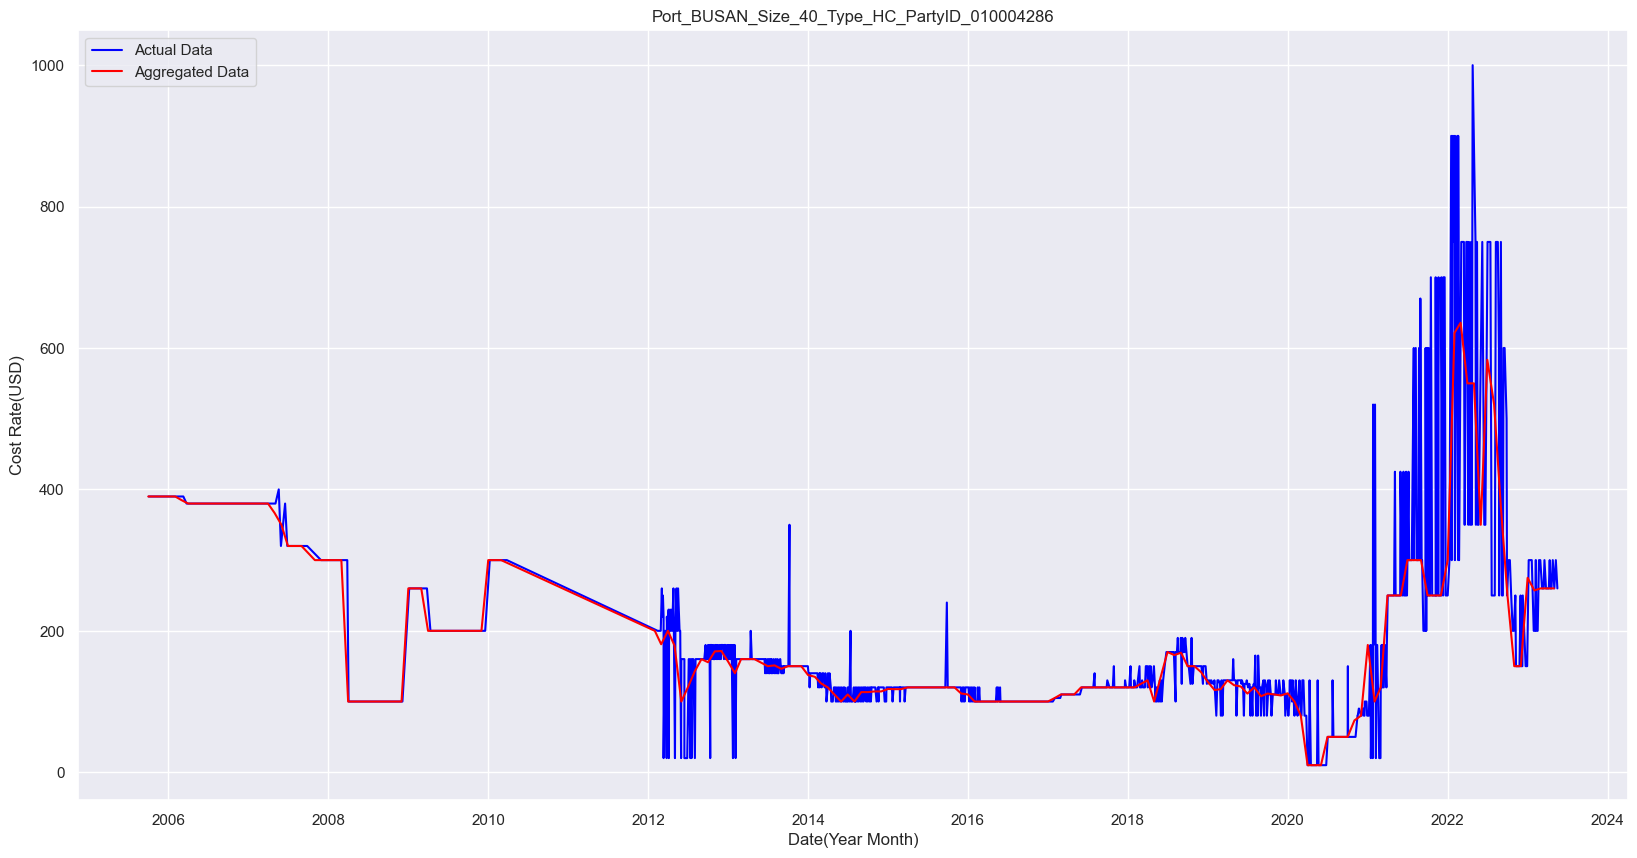

In [132]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonth'], agg_df['Rate'], color='red', label="Aggregated Data")

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();

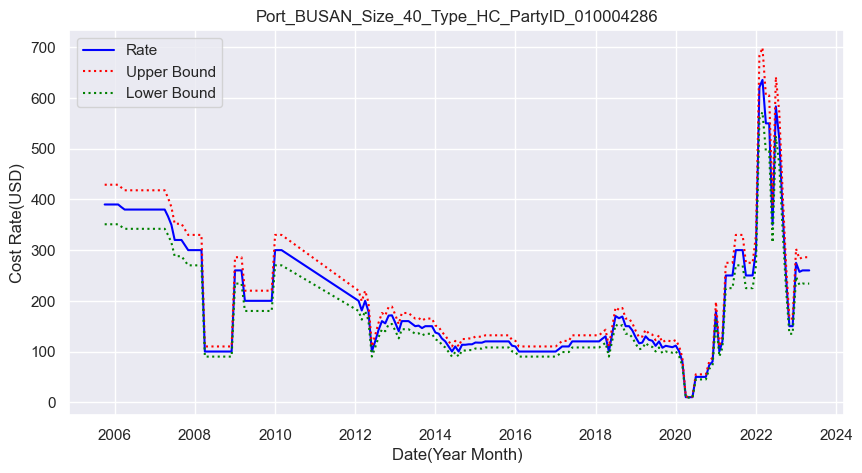

In [133]:
plt.figure(figsize=(10, 5))
plt.plot(agg_df['YearMonth'], agg_df['Rate'], color='blue', label='Rate')

# Calculate upper and lower bounds for aggr value for "Rate"
upper_bound = agg_df['Rate'] * 1.10
lower_bound = agg_df['Rate'] * 0.90

# Plot upper and lower bounds as dotted lines
plt.plot(agg_df['YearMonth'], upper_bound, linestyle='dotted', color='red', label='Upper Bound')
plt.plot(agg_df['YearMonth'], lower_bound, linestyle='dotted', color='green', label='Lower Bound')

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();


<h4>Mean Square Error Evaluation Function</h4>

In [134]:
# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

<h4>Plot Prediction Function to see model fitting</h4>

In [135]:
def plot_predictions_v1(df, trainPredict, testPredict, look_back):
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(df)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(df)
    testPredictPlot[:, :] = np.nan
    print(f'testPredict shape: {testPredict.shape}')
    print(f'testPredictPlot section shape: {testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :].shape}')
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :1] = testPredict

    # plot baseline and predictions
    plt.figure(figsize=(15,8))
    plt.plot(scaler.inverse_transform(df), color='blue', label='Actual Data')
    plt.plot(trainPredictPlot, color='orange', label='Training Fit')
    plt.plot(testPredictPlot, color='green', label='Testing Prediction')
    plt.legend(loc='upper left')
    plt.show()

In [136]:
def plot_predictions_v2(df, trainPredict, testPredict, look_back):
    # Shift train predictions for plotting
    trainPredictPlot = np.empty_like(df)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :1] = trainPredict

    # Shift test predictions for plotting
    testPredictPlot = np.empty_like(df)
    testPredictPlot[:, :] = np.nan
    print(f'testPredict shape: {testPredict.shape}')
    print(f'testPredictPlot section shape: {testPredictPlot[len(trainPredict)+look_back:len(df), :].shape}')
    testPredictPlot[len(trainPredict)+(look_back*2):len(df), :1] = testPredict

    # plot baseline and predictions
    plt.figure(figsize=(15,8))
    plt.plot(scaler.inverse_transform(df['Rate'].values.reshape(-1,1)), color='blue', label='Actual Data')
    plt.plot(trainPredictPlot, color='orange', label='Training Fit')
    plt.plot(testPredictPlot, color='green', label='Testing Prediction')
    plt.legend(loc='upper left')
    plt.show()


<h4>LSTM Regression<h4>

In [137]:
# Dataframe for LSTM
df_lstm1 = agg_df[['YearMonth','Rate']]
df_lstm1.head()
df_lstm1.info()

,YearMonth,Rate
0,2005-10-01,390.0
1,2005-11-01,390.0
2,2005-12-01,390.0
3,2006-01-01,390.0
4,2006-02-01,390.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   YearMonth  185 non-null    datetime64[ns]
 1   Rate       185 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


In [ ]:
# Restructure time series data for LSTM model
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def create_LSTM_model(trainX, trainY, testX, testY, epochs):
    # LSTM model
    model = Sequential()
    model.add(LSTM(4, input_shape=(trainX.shape[1], trainX.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the model and store the history
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2, validation_data=(testX, testY))
    return model, history

def plot_train_val_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()


Training for 50 epochs...
Epoch 1/50
127/127 - 2s - loss: 0.0743 - val_loss: 0.0947 - 2s/epoch - 14ms/step
Epoch 2/50
127/127 - 0s - loss: 0.0314 - val_loss: 0.0643 - 217ms/epoch - 2ms/step
Epoch 3/50
127/127 - 0s - loss: 0.0223 - val_loss: 0.0575 - 216ms/epoch - 2ms/step
Epoch 4/50
127/127 - 0s - loss: 0.0202 - val_loss: 0.0525 - 212ms/epoch - 2ms/step
Epoch 5/50
127/127 - 0s - loss: 0.0187 - val_loss: 0.0488 - 214ms/epoch - 2ms/step
Epoch 6/50
127/127 - 0s - loss: 0.0170 - val_loss: 0.0448 - 217ms/epoch - 2ms/step
Epoch 7/50
127/127 - 0s - loss: 0.0155 - val_loss: 0.0410 - 223ms/epoch - 2ms/step
Epoch 8/50
127/127 - 0s - loss: 0.0140 - val_loss: 0.0372 - 217ms/epoch - 2ms/step
Epoch 9/50
127/127 - 0s - loss: 0.0124 - val_loss: 0.0338 - 212ms/epoch - 2ms/step
Epoch 10/50
127/127 - 0s - loss: 0.0109 - val_loss: 0.0307 - 242ms/epoch - 2ms/step
Epoch 11/50
127/127 - 0s - loss: 0.0093 - val_loss: 0.0276 - 218ms/epoch - 2ms/step
Epoch 12/50
127/127 - 0s - loss: 0.0080 - val_loss: 0.0249 - 

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

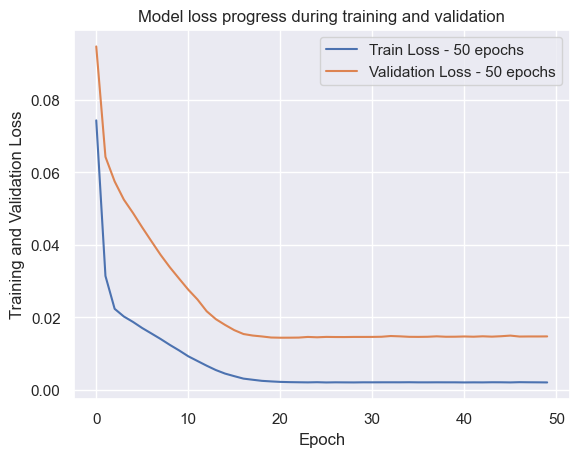

2/2 [==============================] - 0s 2ms/step
Train Score: 28.52 RMSE for 50 epochs
Test Score: 75.97 RMSE for 50 epochs
Training for 100 epochs...
Epoch 1/100
127/127 - 2s - loss: 0.0500 - val_loss: 0.0638 - 2s/epoch - 13ms/step
Epoch 2/100
127/127 - 0s - loss: 0.0197 - val_loss: 0.0445 - 222ms/epoch - 2ms/step
Epoch 3/100
127/127 - 0s - loss: 0.0145 - val_loss: 0.0395 - 230ms/epoch - 2ms/step
Epoch 4/100
127/127 - 0s - loss: 0.0129 - val_loss: 0.0354 - 243ms/epoch - 2ms/step
Epoch 5/100
127/127 - 0s - loss: 0.0116 - val_loss: 0.0320 - 220ms/epoch - 2ms/step
Epoch 6/100
127/127 - 0s - loss: 0.0103 - val_loss: 0.0294 - 219ms/epoch - 2ms/step
Epoch 7/100
127/127 - 0s - loss: 0.0089 - val_loss: 0.0261 - 221ms/epoch - 2ms/step
Epoch 8/100
127/127 - 0s - loss: 0.0077 - val_loss: 0.0241 - 221ms/epoch - 2ms/step
Epoch 9/100
127/127 - 0s - loss: 0.0066 - val_loss: 0.0215 - 219ms/epoch - 2ms/step
Epoch 10/100
127/127 - 0s - loss: 0.0055 - val_loss: 0.0196 - 218ms/epoch - 2ms/step
Epoch 11

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

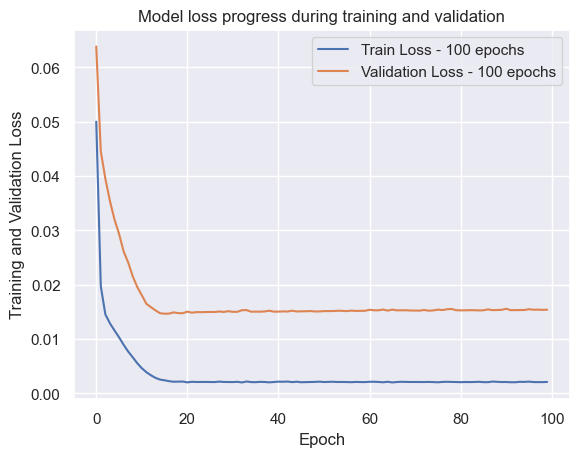

2/2 [==============================] - 0s 2ms/step
Train Score: 27.87 RMSE for 100 epochs
Test Score: 77.60 RMSE for 100 epochs
Training for 300 epochs...
Epoch 1/300
127/127 - 2s - loss: 0.0989 - val_loss: 0.1268 - 2s/epoch - 13ms/step
Epoch 2/300
127/127 - 0s - loss: 0.0472 - val_loss: 0.0919 - 214ms/epoch - 2ms/step
Epoch 3/300
127/127 - 0s - loss: 0.0332 - val_loss: 0.0797 - 214ms/epoch - 2ms/step
Epoch 4/300
127/127 - 0s - loss: 0.0294 - val_loss: 0.0738 - 214ms/epoch - 2ms/step
Epoch 5/300
127/127 - 0s - loss: 0.0276 - val_loss: 0.0696 - 214ms/epoch - 2ms/step
Epoch 6/300
127/127 - 0s - loss: 0.0262 - val_loss: 0.0665 - 218ms/epoch - 2ms/step
Epoch 7/300
127/127 - 0s - loss: 0.0248 - val_loss: 0.0630 - 212ms/epoch - 2ms/step
Epoch 8/300
127/127 - 0s - loss: 0.0237 - val_loss: 0.0602 - 216ms/epoch - 2ms/step
Epoch 9/300
127/127 - 0s - loss: 0.0225 - val_loss: 0.0578 - 214ms/epoch - 2ms/step
Epoch 10/300
127/127 - 0s - loss: 0.0212 - val_loss: 0.0540 - 210ms/epoch - 2ms/step
Epoch 

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

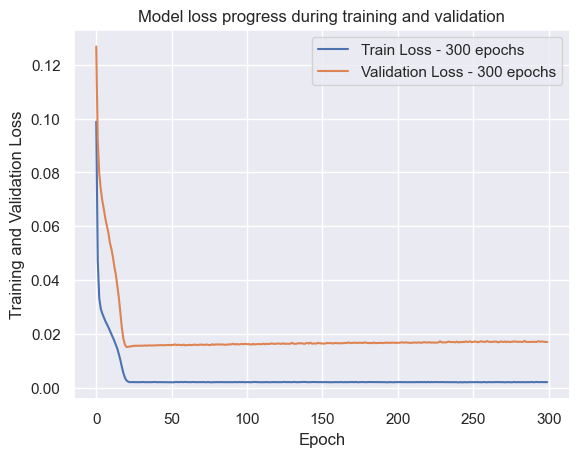

2/2 [==============================] - 0s 3ms/step
Train Score: 27.75 RMSE for 300 epochs
Test Score: 81.57 RMSE for 300 epochs
Training for 500 epochs...
Epoch 1/500
127/127 - 2s - loss: 0.0391 - val_loss: 0.0472 - 2s/epoch - 13ms/step
Epoch 2/500
127/127 - 0s - loss: 0.0135 - val_loss: 0.0338 - 232ms/epoch - 2ms/step
Epoch 3/500
127/127 - 0s - loss: 0.0106 - val_loss: 0.0298 - 211ms/epoch - 2ms/step
Epoch 4/500
127/127 - 0s - loss: 0.0094 - val_loss: 0.0270 - 215ms/epoch - 2ms/step
Epoch 5/500
127/127 - 0s - loss: 0.0081 - val_loss: 0.0250 - 233ms/epoch - 2ms/step
Epoch 6/500
127/127 - 0s - loss: 0.0071 - val_loss: 0.0220 - 220ms/epoch - 2ms/step
Epoch 7/500
127/127 - 0s - loss: 0.0058 - val_loss: 0.0199 - 214ms/epoch - 2ms/step
Epoch 8/500
127/127 - 0s - loss: 0.0049 - val_loss: 0.0179 - 219ms/epoch - 2ms/step
Epoch 9/500
127/127 - 0s - loss: 0.0041 - val_loss: 0.0167 - 211ms/epoch - 2ms/step
Epoch 10/500
127/127 - 0s - loss: 0.0034 - val_loss: 0.0157 - 214ms/epoch - 2ms/step
Epoch 

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

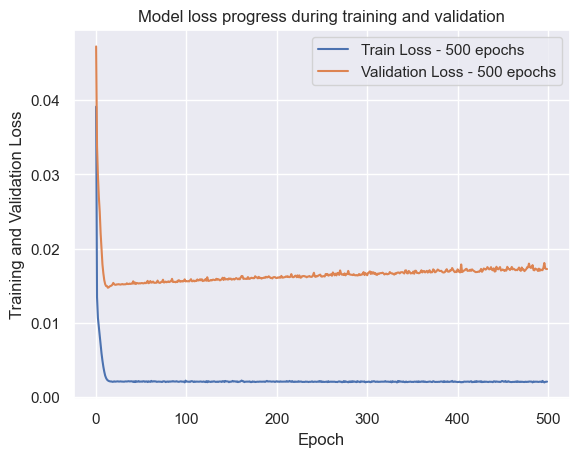

2/2 [==============================] - 0s 3ms/step
Train Score: 27.76 RMSE for 500 epochs
Test Score: 82.16 RMSE for 500 epochs
Training for 1000 epochs...
Epoch 1/1000
127/127 - 2s - loss: 0.0519 - val_loss: 0.0665 - 2s/epoch - 14ms/step
Epoch 2/1000
127/127 - 0s - loss: 0.0201 - val_loss: 0.0484 - 222ms/epoch - 2ms/step
Epoch 3/1000
127/127 - 0s - loss: 0.0166 - val_loss: 0.0443 - 214ms/epoch - 2ms/step
Epoch 4/1000
127/127 - 0s - loss: 0.0150 - val_loss: 0.0399 - 211ms/epoch - 2ms/step
Epoch 5/1000
127/127 - 0s - loss: 0.0134 - val_loss: 0.0364 - 213ms/epoch - 2ms/step
Epoch 6/1000
127/127 - 0s - loss: 0.0118 - val_loss: 0.0326 - 211ms/epoch - 2ms/step
Epoch 7/1000
127/127 - 0s - loss: 0.0103 - val_loss: 0.0298 - 211ms/epoch - 2ms/step
Epoch 8/1000
127/127 - 0s - loss: 0.0087 - val_loss: 0.0256 - 209ms/epoch - 2ms/step
Epoch 9/1000
127/127 - 0s - loss: 0.0074 - val_loss: 0.0228 - 212ms/epoch - 2ms/step
Epoch 10/1000
127/127 - 0s - loss: 0.0061 - val_loss: 0.0204 - 213ms/epoch - 2ms/

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

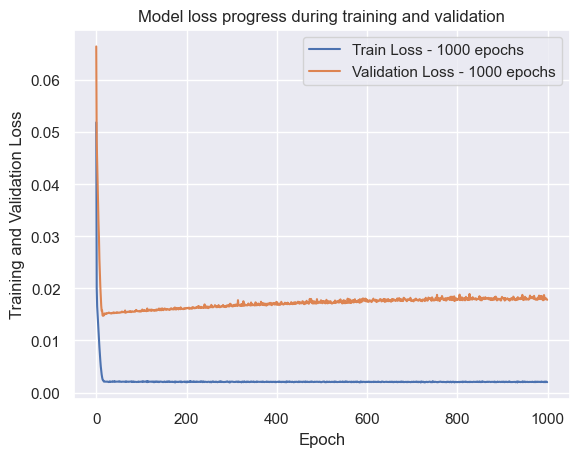

2/2 [==============================] - 0s 2ms/step
Train Score: 28.91 RMSE for 1000 epochs
Test Score: 83.50 RMSE for 1000 epochs
      Train RMSE  Test RMSE
50     28.515716  75.973125
100    27.869292  77.597237
300    27.749212  81.567833
500    27.756273  82.156229
1000   28.910119  83.496079


In [141]:
# Normalize dataset for LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_lstm1['Rate'].values.reshape(-1,1))

# Split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

epochs_list = [50, 100, 300, 500, 1000]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    model, history = create_LSTM_model(trainX, trainY, testX, testY, epochs)
    
    # Add the loss for this model to the plot
    plt.plot(history.history['loss'], label=f'Train Loss - {epochs} epochs')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - {epochs} epochs')

    # Configure and show the plot
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show();

    # Evalute LSTM Model
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions back to prescaled values
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_orig = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY_orig = scaler.inverse_transform([testY])

    # Calculate mean squared error
    trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:,0])
    print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
    testScore = calculate_RMSE(testY_orig[0], testPredict[:,0])
    print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

    rmse_results[epochs] = {'Train RMSE': trainScore, 'Test RMSE': testScore}

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)

# # View how LSTM model fitting to the actual data
# plot_predictions_v1(dataset, trainPredict, testPredict, look_back)


From the above RMSE value is it still consider large. It still could be the abrupt changes during covid season from 2020 - 2022 can be difficult for LSTM regression Model as it might be confused as predictions is based on historical data and there is a suddent change in these patterns. Therefore, the model might be "confused".

Will be trying to incorporate external features into my model to indicate covid-19 presence and indicate using binary variable for rates.
1. 0 is for pre-covid
2. 1 is for post-covid 

This is to help the model to better understand the impact of Covid-19. Tried anomaly detection. However, there isnt enough data to train the anomaly detection.

<h4>Testing LSTM Regression model with external features</h4>

In [142]:
def create_dataset_v2(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

,YearMonth,Rate,Covid
0,2005-10-01,390.0,0
1,2005-11-01,390.0,0
2,2005-12-01,390.0,0
3,2006-01-01,390.0,0
4,2006-02-01,390.0,0


,YearMonth,Rate,Covid
180,2023-01-01,275.000000,1
181,2023-02-01,257.142857,0
182,2023-03-01,260.000000,0
183,2023-04-01,260.000000,0
184,2023-05-01,260.000000,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   YearMonth  185 non-null    datetime64[ns]
 1   Rate       185 non-null    float64       
 2   Covid      185 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.5 KB
Training for 50 epochs...
Epoch 1/50
128/128 - 2s - loss: 0.0785 - val_loss: 0.1324 - 2s/epoch - 19ms/step
Epoch 2/50
128/128 - 0s - loss: 0.0334 - val_loss: 0.1018 - 216ms/epoch - 2ms/step
Epoch 3/50
128/128 - 0s - loss: 0.0244 - val_loss: 0.0927 - 219ms/epoch - 2ms/step
Epoch 4/50
128/128 - 0s - loss: 0.0221 - val_loss: 0.0906 - 216ms/epoch - 2ms/step
Epoch 5/50
128/128 - 0s - loss: 0.0205 - val_loss: 0.0871 - 214ms/epoch - 2ms/step
Epoch 6/50
128/128 - 0s - loss: 0.0191 - val_loss: 0.0850 - 218ms/epoch - 2ms/step
Epoch 7/50
128/128 - 0s - loss: 0.0174 - val_loss: 0.0878 - 222ms/epoc

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

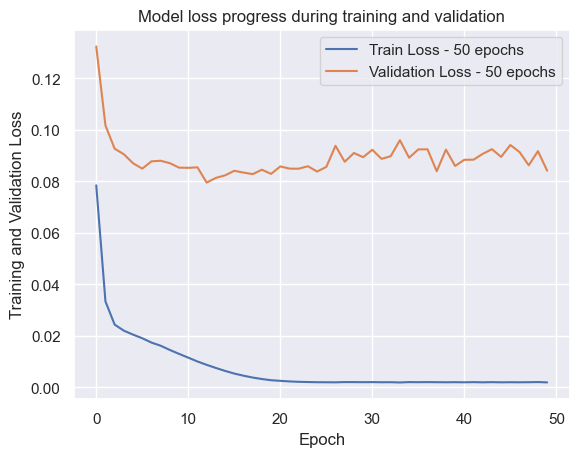

2/2 [==============================] - 0s 3ms/step
Train Score: 28.81 RMSE for 50 epochs
Test Score: 181.55 RMSE for 50 epochs
Training for 100 epochs...
Epoch 1/100
128/128 - 2s - loss: 0.0825 - val_loss: 0.1179 - 2s/epoch - 13ms/step
Epoch 2/100
128/128 - 0s - loss: 0.0351 - val_loss: 0.0849 - 216ms/epoch - 2ms/step
Epoch 3/100
128/128 - 0s - loss: 0.0259 - val_loss: 0.0755 - 220ms/epoch - 2ms/step
Epoch 4/100
128/128 - 0s - loss: 0.0237 - val_loss: 0.0707 - 243ms/epoch - 2ms/step
Epoch 5/100
128/128 - 0s - loss: 0.0223 - val_loss: 0.0675 - 214ms/epoch - 2ms/step
Epoch 6/100
128/128 - 0s - loss: 0.0209 - val_loss: 0.0647 - 211ms/epoch - 2ms/step
Epoch 7/100
128/128 - 0s - loss: 0.0194 - val_loss: 0.0619 - 215ms/epoch - 2ms/step
Epoch 8/100
128/128 - 0s - loss: 0.0180 - val_loss: 0.0589 - 212ms/epoch - 2ms/step
Epoch 9/100
128/128 - 0s - loss: 0.0165 - val_loss: 0.0560 - 217ms/epoch - 2ms/step
Epoch 10/100
128/128 - 0s - loss: 0.0151 - val_loss: 0.0541 - 216ms/epoch - 2ms/step
Epoch 1

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

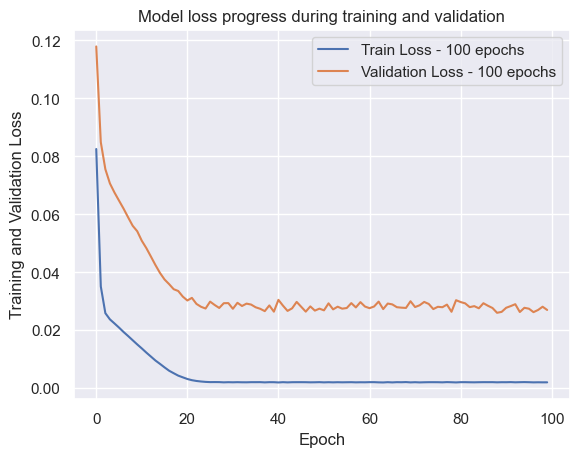

2/2 [==============================] - 0s 3ms/step
Train Score: 27.83 RMSE for 100 epochs
Test Score: 102.79 RMSE for 100 epochs
Training for 300 epochs...
Epoch 1/300
128/128 - 2s - loss: 0.0618 - val_loss: 0.0627 - 2s/epoch - 14ms/step
Epoch 2/300
128/128 - 0s - loss: 0.0246 - val_loss: 0.0482 - 222ms/epoch - 2ms/step
Epoch 3/300
128/128 - 0s - loss: 0.0185 - val_loss: 0.0443 - 216ms/epoch - 2ms/step
Epoch 4/300
128/128 - 0s - loss: 0.0167 - val_loss: 0.0407 - 214ms/epoch - 2ms/step
Epoch 5/300
128/128 - 0s - loss: 0.0151 - val_loss: 0.0374 - 214ms/epoch - 2ms/step
Epoch 6/300
128/128 - 0s - loss: 0.0136 - val_loss: 0.0340 - 222ms/epoch - 2ms/step
Epoch 7/300
128/128 - 0s - loss: 0.0120 - val_loss: 0.0308 - 218ms/epoch - 2ms/step
Epoch 8/300
128/128 - 0s - loss: 0.0105 - val_loss: 0.0278 - 219ms/epoch - 2ms/step
Epoch 9/300
128/128 - 0s - loss: 0.0090 - val_loss: 0.0250 - 216ms/epoch - 2ms/step
Epoch 10/300
128/128 - 0s - loss: 0.0077 - val_loss: 0.0228 - 218ms/epoch - 2ms/step
Epoch

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

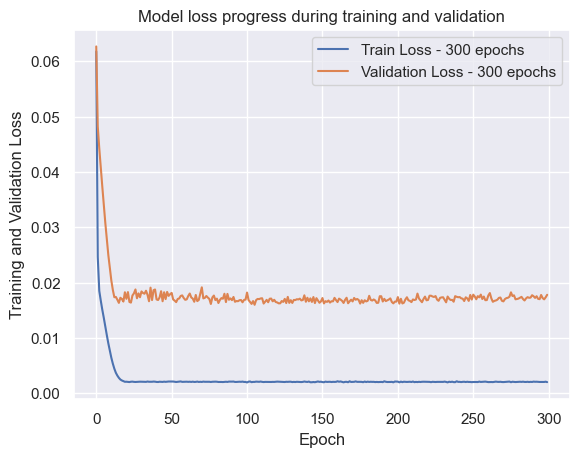

2/2 [==============================] - 0s 3ms/step
Train Score: 28.13 RMSE for 300 epochs
Test Score: 83.44 RMSE for 300 epochs
Training for 500 epochs...
Epoch 1/500
128/128 - 2s - loss: 0.0758 - val_loss: 0.1203 - 2s/epoch - 14ms/step
Epoch 2/500
128/128 - 0s - loss: 0.0325 - val_loss: 0.0780 - 221ms/epoch - 2ms/step
Epoch 3/500
128/128 - 0s - loss: 0.0220 - val_loss: 0.0630 - 221ms/epoch - 2ms/step
Epoch 4/500
128/128 - 0s - loss: 0.0194 - val_loss: 0.0557 - 221ms/epoch - 2ms/step
Epoch 5/500
128/128 - 0s - loss: 0.0178 - val_loss: 0.0498 - 215ms/epoch - 2ms/step
Epoch 6/500
128/128 - 0s - loss: 0.0161 - val_loss: 0.0432 - 217ms/epoch - 2ms/step
Epoch 7/500
128/128 - 0s - loss: 0.0143 - val_loss: 0.0376 - 216ms/epoch - 2ms/step
Epoch 8/500
128/128 - 0s - loss: 0.0122 - val_loss: 0.0307 - 215ms/epoch - 2ms/step
Epoch 9/500
128/128 - 0s - loss: 0.0097 - val_loss: 0.0254 - 224ms/epoch - 2ms/step
Epoch 10/500
128/128 - 0s - loss: 0.0074 - val_loss: 0.0224 - 215ms/epoch - 2ms/step
Epoch 

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

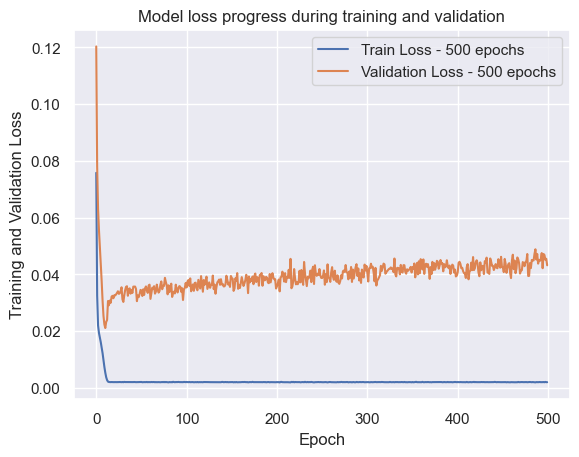

2/2 [==============================] - 0s 2ms/step
Train Score: 27.73 RMSE for 500 epochs
Test Score: 130.06 RMSE for 500 epochs
Training for 1000 epochs...
Epoch 1/1000
128/128 - 2s - loss: 0.0625 - val_loss: 0.1019 - 2s/epoch - 14ms/step
Epoch 2/1000
128/128 - 0s - loss: 0.0265 - val_loss: 0.0757 - 218ms/epoch - 2ms/step
Epoch 3/1000
128/128 - 0s - loss: 0.0191 - val_loss: 0.0675 - 218ms/epoch - 2ms/step
Epoch 4/1000
128/128 - 0s - loss: 0.0174 - val_loss: 0.0668 - 217ms/epoch - 2ms/step
Epoch 5/1000
128/128 - 0s - loss: 0.0161 - val_loss: 0.0667 - 213ms/epoch - 2ms/step
Epoch 6/1000
128/128 - 0s - loss: 0.0148 - val_loss: 0.0662 - 213ms/epoch - 2ms/step
Epoch 7/1000
128/128 - 0s - loss: 0.0134 - val_loss: 0.0650 - 214ms/epoch - 2ms/step
Epoch 8/1000
128/128 - 0s - loss: 0.0120 - val_loss: 0.0634 - 249ms/epoch - 2ms/step
Epoch 9/1000
128/128 - 0s - loss: 0.0106 - val_loss: 0.0660 - 224ms/epoch - 2ms/step
Epoch 10/1000
128/128 - 0s - loss: 0.0092 - val_loss: 0.0666 - 247ms/epoch - 2ms

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

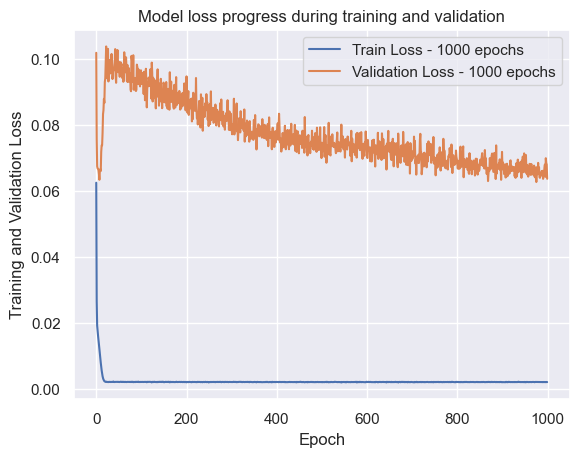

2/2 [==============================] - 0s 2ms/step
Train Score: 27.89 RMSE for 1000 epochs
Test Score: 157.89 RMSE for 1000 epochs
      Train RMSE   Test RMSE
50     28.809689  181.547308
100    27.831204  102.793900
300    28.131981   83.436066
500    27.725453  130.060933
1000   27.894288  157.888353


In [143]:
# Dataframe for LSTM2
df_lstm2 = agg_df[['YearMonth','Rate']].copy()

# Create a new column indicating whether each month is affected by COVID-19
df_lstm2['Covid'] = 0
df_lstm2.loc[(df_lstm2['YearMonth'] >= '2020-01') & (df_lstm2['YearMonth'] <= '2023-01'), 'Covid'] = 1

df_lstm2.head()
df_lstm2.tail()
df_lstm2.info()

# Fit a separate scaler for 'Rate'
scaler_rate = MinMaxScaler(feature_range=(0, 1))
df_lstm2['Rate'] = scaler_rate.fit_transform(df_lstm2['Rate'].values.reshape(-1,1))

# Split into train and test sets
train_size = int(len(df_lstm2) * 0.7)
test_size = len(df_lstm2) - train_size
train, test = df_lstm2.iloc[0:train_size,:], df_lstm2.iloc[train_size:len(df_lstm2),:]

# Prepare data for LSTM
look_back = 1
trainX, trainY = create_dataset_v2(train['Rate'].values, look_back)
testX, testY = create_dataset_v2(test['Rate'].values, look_back)

# Add Covid column to the features
trainX = np.hstack((trainX, train['Covid'][:-look_back].values.reshape(-1,1)))
testX = np.hstack((testX, test['Covid'][:-look_back].values.reshape(-1,1)))

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

epochs_list = [50, 100, 300, 500, 1000]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    model, history = create_LSTM_model(trainX, trainY, testX, testY, epochs)
    
    # Add the loss for this model to the plot
    plt.plot(history.history['loss'], label=f'Train Loss - {epochs} epochs')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - {epochs} epochs')

    # Configure and show the plot
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show();

    # Evalute LSTM Model
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions back to prescaled values
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_orig = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY_orig = scaler.inverse_transform([testY])

    # Calculate mean squared error
    trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:,0])
    print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
    testScore = calculate_RMSE(testY_orig[0], testPredict[:,0])
    print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

    rmse_results[epochs] = {'Train RMSE': trainScore, 'Test RMSE': testScore}

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)


# # Plot predictions
# plot_predictions_v2(df_lstm2, trainPredict, testPredict, look_back)


<h4>Modeling For ARIMA<h4>

In [144]:
# Dataframe for ARIMA For Log Transform
df_arima1 = agg_df[['YearMonth','Rate']].copy()
df_arima1.set_index('YearMonth', inplace=True)
df_arima1.head()
df_arima1.info()

# Dataframe for ARIMA 
df_arima2 = agg_df[['YearMonth','Rate']].copy()
df_arima2.set_index('YearMonth', inplace=True)
df_arima2.head()
df_arima2.info()

,Rate
YearMonth,
2005-10-01,390.0
2005-11-01,390.0
2005-12-01,390.0
2006-01-01,390.0
2006-02-01,390.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 185 entries, 2005-10-01 to 2023-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rate    185 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


,Rate
YearMonth,
2005-10-01,390.0
2005-11-01,390.0
2005-12-01,390.0
2006-01-01,390.0
2006-02-01,390.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 185 entries, 2005-10-01 to 2023-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rate    185 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error

# Apply logarithm transformation to 'Rate' column
df_arima1['Rate'] = np.log(df_arima1['Rate'])

# Fit an auto_arima model
arima_model1 = pm.auto_arima(df_arima1['Rate'], start_p=1, start_q=1, 
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=False, 
                            d=1, D=1, trace=True,
                            error_action='ignore',  # don't want to know if an order does not work
                            suppress_warnings=True,  # don't want convergence warnings
                            stepwise=True)  # set to stepwise

# Print the summary of the model
print(arima_model1.summary())

# Split the data into training and test data
train_size1 = int(len(df_arima1) * 0.7)
train1, test1 = df_arima1[0:train_size1], df_arima1[train_size1:]

# Train the model on the training data
arima_model1.fit(train['Rate'])

# Forecast
train_forecast1, conf_int_train1 = arima_model1.predict(n_periods=len(train1), return_conf_int=True)
test_forecast1, conf_int_test1 = arima_model1.predict(n_periods=len(test1), return_conf_int=True)

# Reverse the logarithm transformation
train1['Rate'] = np.exp(train1['Rate'])
test1['Rate'] = np.exp(test1['Rate'])
train_forecast1 = np.exp(train_forecast1)
test_forecast1 = np.exp(test_forecast1)
conf_int_train1 = np.exp(conf_int_train1)
conf_int_test1 = np.exp(conf_int_test1)

# Calculate the RMSE
RMSE_ARIMA_train1 = np.sqrt(mean_squared_error(train1['Rate'], train_forecast1))
print("Train RMSE: %.3f" % RMSE_ARIMA_train1)
RMSE_ARIMA_test1 = np.sqrt(mean_squared_error(test1['Rate'], test_forecast1))
print("Test RMSE: %.3f" % RMSE_ARIMA_test1)


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-440.153, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-439.677, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-437.788, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-437.786, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-441.672, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.417 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  185
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 221.836
Date:                Mon, 19 Jun 2023   AIC                           -441.672
Time:                        20:45:00   BIC                           -438.457
Sample:                             0   HQIC                          -440.369
                                - 185                                       

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Train RMSE: 3.850
Test RMSE: 3.838


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_25904\3072854943.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1['Rate'] = np.exp(train1['Rate'])
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_25904\3072854943.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['Rate'] = np.exp(test1['Rate'])


In [147]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error

# Split the data into training and test data
train_size2 = int(len(df_arima2) * 0.7)
train2, test2 = df_arima2[0:train_size2], df_arima2[train_size2:]

# Fit an auto_arima model
arima_model2 = pm.auto_arima(train2['Rate'], start_p=1, start_q=1, 
                            max_p=12, max_q=12, m=12,
                            start_P=0, seasonal=False, 
                            d=0, D=0, trace=True,
                            error_action='ignore', 
                            suppress_warnings=True, 
                            stepwise=True)  # set to stepwise

# Print the summary of the model
print(arima_model2.summary())

# Forecast
train_forecast2 = arima_model2.predict_in_sample()
test_forecast2 = arima_model2.predict(n_periods=len(test2))

# Calculate the RMSE
RMSE_ARIMA_train2 = np.sqrt(mean_squared_error(train2['Rate'], train_forecast2))
print("Train RMSE: %.3f" % RMSE_ARIMA_train2)
RMSE_ARIMA_test2 = np.sqrt(mean_squared_error(test2['Rate'], test_forecast2))
print("Test RMSE: %.3f" % RMSE_ARIMA_test2)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1242.360, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1749.655, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1606.739, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1240.373, Time=0.07 sec


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1240.903, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1240.247, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1244.188, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1239.075, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1242.982, Time=0.10 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1238.314, Time=0.30 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=1236.961, Time=0.31 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=1241.535, Time=0.23 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=1238.940, Time=0.37 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=1242.493, Time=0.34 sec
 ARIMA(5,0,4)(0,0,0)[0]             : AIC=1240.537, Time=0.38 sec
 ARIMA(4,0,3)(0,0,0)[0] interc

c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
